# **Optimizing Product Recommendations Using a Hybrid Filtering System**
This notebook demonstrates the development of a hybrid recommendation system combining Content-Based Filtering and Collaborative Filtering to optimize product recommendations in e-commerce. Using the Amazon 2023 dataset—which includes 571.54 million product reviews and detailed metadata, though we are only focusing on the Electronics portion specifically—the system addresses challenges like the cold start problem and enhances recommendation diversity. The approach integrates metadata such as categories, features, and ratings with user interaction data to compute similarity scores. A hybrid method balances the strengths of both algorithms to generate relevant product suggestions. The notebook covers data preprocessing and algorithm implementation with an emphasis on improving relevance, diversity, and performance.

Link to dataset: https://www.kaggle.com/datasets/lokeshparab/amazon-products-dataset/data?select=All+Electronics.csv

Download the All Electronics.csv dataset

In [ ]:
!pip install --upgrade torch
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [ ]:
!pip install kagglehub      # Annapia added this to download the dataset directly from Kaggle

# **Ravi:** *EDA & Data Cleaning*
This code performs Exploratory Data Analysis (EDA) and data cleaning to prepare a dataset of Amazon electronics products for further analysis and modeling. The workflow begins by inspecting the dataset, identifying missing or inconsistent data, and cleaning key columns such as prices, ratings, and the number of ratings by removing non-numeric characters, converting data types, and filtering invalid entries. Missing values in essential columns are also dropped to ensure data integrity.

Additional preprocessing steps include extracting manufacturer names from product titles, calculating discounts and discount percentages, and reorganizing columns for better clarity. The code also provides insights into popular brands and customer satisfaction by visualizing the top 15 manufacturers and their product counts, as well as computing average ratings. To account for potential biases, such as fake or paid reviews, the analysis narrows down to brands with significant purchase volumes to highlight reliable trends. This cleaned and processed dataset serves as a robust foundation for building recommendation systems and conducting further analysis.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

In [ ]:
path = kagglehub.dataset_download("lokeshparab/amazon-products-dataset")

100%|██████████| 79.7M/79.7M [00:02<00:00, 35.6MB/s]

Extracting files...


In [ ]:
# Load dataset
data = pd.read_csv(f"{path}/All Electronics.csv")

In [ ]:
data.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965,"₹10,999","₹18,999"
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,"113,956","₹18,999","₹19,999"
2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,"90,304","₹1,999","₹2,299"
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,"24,863","₹15,999","₹24,999"
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,"113,956","₹18,999","₹19,999"


In [ ]:
# Size of dataset
data.shape

(9600, 9)

In [ ]:
# Check for missing values
data.isnull().sum()

,0
name,0
main_category,0
sub_category,0
image,0
link,0
ratings,95
no_of_ratings,95
discount_price,484
actual_price,70


In [ ]:
# Check unique values
data.nunique()

,0
name,8800
main_category,1
sub_category,1
image,9321
link,9600
ratings,39
no_of_ratings,3455
discount_price,1608
actual_price,1068


In [ ]:
# Let us take a look at the column names
pd.DataFrame(data.columns, columns=['Column Names'])

,Column Names
0,name
1,main_category
2,sub_category
3,image
4,link
5,ratings
6,no_of_ratings
7,discount_price
8,actual_price


In [ ]:
# Look at datatype of the Dataframe
data.dtypes

,0
name,object
main_category,object
sub_category,object
image,object
link,object
ratings,object
no_of_ratings,object
discount_price,object
actual_price,object


Need to convert 'ratings', 'no_of_ratings', 'discount_price', 'actual_price' into float dtype.

For that we need to first remove non-float characters

In [ ]:
# Remove '₹' from columns 'actual_price' and 'discount_price'
# '₹' is the symbol for Indian currency 'Rupee'
data['actual_price'] = data['actual_price'].str.replace('₹', '')
data['discount_price'] = data['discount_price'].str.replace('₹', '')

In [ ]:
# Finally convert into float. Need to remove commas from price.
# For e.g. 18,999 needs to be converted to 18999
data['actual_price'] = data['actual_price'].str.replace(',','').astype(float)
data['discount_price'] = data['discount_price'].str.replace(',','').astype(float)

In [ ]:
# Let us look at unique value(s) in ratings
data['ratings'].unique()

array(['4.0', '4.3', '4.2', '4.1', '3.9', '4.6', '3.8', 'Get', '4.4',
       '3.5', '3.7', '4.5', '3.3', '3.6', '3.4', nan, '3.2', '2.9', '4.7',
       '5.0', '2.5', '2.8', '4.8', '3.1', '3.0', '2.3', '2.7', '2.4',
       '4.9', '1.7', '1.5', '2.6', '1.8', '1.3', '2.1', '1.9', '2.2',
       '1.0', '1.4', '2.0'], dtype=object)

In [ ]:
# Need to remove 'Get', and convert to float
data['ratings'] = data['ratings'].str.replace('Get','0.0').astype(float)

In [ ]:
# Converted to float dtype
data['ratings'].unique()

array([4. , 4.3, 4.2, 4.1, 3.9, 4.6, 3.8, 0. , 4.4, 3.5, 3.7, 4.5, 3.3,
       3.6, 3.4, nan, 3.2, 2.9, 4.7, 5. , 2.5, 2.8, 4.8, 3.1, 3. , 2.3,
       2.7, 2.4, 4.9, 1.7, 1.5, 2.6, 1.8, 1.3, 2.1, 1.9, 2.2, 1. , 1.4,
       2. ])

The column 'no_of_ratings' has entries which do not start with a number. We need to remove those entries first, and then convert the column into float dtype.

For this we create a boolean column which returns True if the entry starts with a number, else False.

In [ ]:
# Convert into str dtype
data['no_of_ratings'] = data['no_of_ratings'].astype(str)

# Create a boolean column 'no_of_ratings_starts_number'
# For each entry x in no_of_ratings, it looks at the 1st character of x
# If the first character is a number, it returns True
data['no_of_ratings_starts_number'] = pd.Series([data['no_of_ratings'][x][0].isdigit() for x in range(len(data['no_of_ratings']))])

# Drop columns with False values
data = data[data['no_of_ratings_starts_number'] == True]

# Count number of remaining values
data['no_of_ratings'].count()

9481

So we did not remove too many columns.

In [ ]:
# Check dtype of 'no_of_ratings'
data['no_of_ratings'].dtype

dtype('O')

In [ ]:
# Convert 'no_of_ratings' to float dtype
# Need to remove commas
data['no_of_ratings'] = data['no_of_ratings'].str.replace(',','').astype(float)

<ipython-input-17-af40c51b5aba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['no_of_ratings'] = data['no_of_ratings'].str.replace(',','').astype(float)


In [ ]:
# Let us look at the cleaned dataset
data.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,no_of_ratings_starts_number
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965.0,10999.0,18999.0,True
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,113956.0,18999.0,19999.0,True
2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,90304.0,1999.0,2299.0,True
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,24863.0,15999.0,24999.0,True
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,113956.0,18999.0,19999.0,True


In [ ]:
# Let us look at the datatypes of each columns again
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9481 entries, 0 to 9599
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         9481 non-null   object 
 1   main_category                9481 non-null   object 
 2   sub_category                 9481 non-null   object 
 3   image                        9481 non-null   object 
 4   link                         9481 non-null   object 
 5   ratings                      9481 non-null   float64
 6   no_of_ratings                9481 non-null   float64
 7   discount_price               9002 non-null   float64
 8   actual_price                 9411 non-null   float64
 9   no_of_ratings_starts_number  9481 non-null   bool   
dtypes: bool(1), float64(4), object(5)
memory usage: 750.0+ KB


In [ ]:
# Look at the statistics of 'ratings' column
data['ratings'].describe()

,ratings
count,9481.000000
mean,4.077576
std,0.377189
min,1.000000
25%,3.900000
50%,4.100000
75%,4.300000
max,5.000000


Looking at the statistics, customer satisfaction with electronic purchases appears generally high. The average rating of 4.0 with a standard deviation of 0.32 suggests that most ratings cluster around the positive end of the scale. Notably, 9481 out of 9600 products have received ratings, indicating widespread customer engagement. However, the presence of a minimum rating of 0.0 warrants further investigation to understand potential sources of dissatisfaction. Overall, while initial observations suggest positive customer sentiment, a deeper analysis of outliers and lower ratings would provide a more comprehensive understanding of customer experience.

In [ ]:
# Dropping columns with missing values for actual_price and discount_price
data = data.dropna(subset=['actual_price', 'discount_price'])

In [ ]:
data.shape

(9002, 10)

In [ ]:
# Let us extract manufacturer name and add is as a column
# Manufacturer name is the 1st word in each entry of 'name' column
data['manufacturer'] = data['name'].str.split().str[0]

<ipython-input-23-b90faaefe773>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['manufacturer'] = data['name'].str.split().str[0]


In [ ]:
# Adjust 'manufacturer' column to be the second column after 'name'
manufacturer = data.pop('manufacturer')
data.insert(1, 'manufacturer', manufacturer)

In [ ]:
data.head()

,name,manufacturer,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,no_of_ratings_starts_number
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...",Redmi,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965.0,10999.0,18999.0,True
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...",OnePlus,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,113956.0,18999.0,19999.0,True
2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,OnePlus,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,90304.0,1999.0,2299.0,True
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...",Samsung,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,24863.0,15999.0,24999.0,True
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...",OnePlus,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,113956.0,18999.0,19999.0,True


In [ ]:
# Add a column with discount and discount percentage
data['discount'] = data['actual_price'] - data['discount_price']
data['discount_percentage'] = (data['discount'] / data['actual_price']) * 100

In [ ]:
data.head()

,name,manufacturer,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,no_of_ratings_starts_number,discount,discount_percentage
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...",Redmi,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965.0,10999.0,18999.0,True,8000.0,42.107479
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...",OnePlus,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,113956.0,18999.0,19999.0,True,1000.0,5.000250
2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,OnePlus,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,90304.0,1999.0,2299.0,True,300.0,13.049152
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...",Samsung,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,24863.0,15999.0,24999.0,True,9000.0,36.001440
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...",OnePlus,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,113956.0,18999.0,19999.0,True,1000.0,5.000250


In [ ]:
# Let us look at the top 15 most popular brands and plot them
popular_brands = data['manufacturer'].value_counts().head(15)

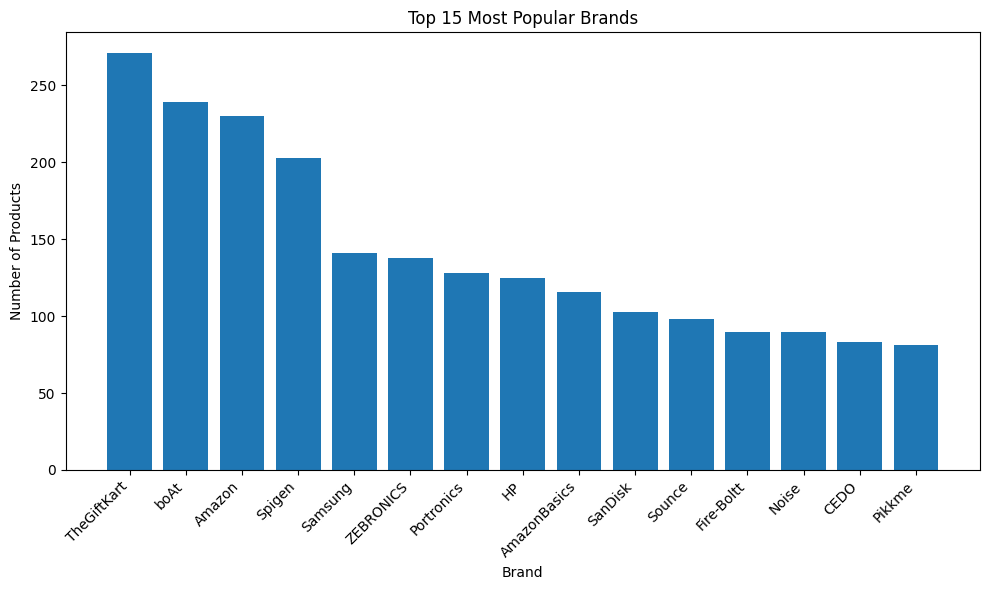

In [ ]:
# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(popular_brands.index, popular_brands.values)

# Customize the plot
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.title("Top 15 Most Popular Brands")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()

- **TheGiftCard**: An Indian brand specializing in mobile and laptop covers, as well as other accessories.  
- **boAt**: A fast-growing Indian brand known for its headphones, offering competitive pricing and reliable quality.


In [ ]:
# Let us look at top 15 brands with highest average ratings
data.groupby('manufacturer')['ratings'].mean().sort_values(ascending=False).head(15)

,ratings
manufacturer,
MKY,5.0
Uvasaggaharam,5.0
ORUM,5.0
LKMO,5.0
Yorten,5.0
A3sprime,5.0
Pecan™,5.0
B,5.0
LTZ,5.0


This can be misleading as the number of products bought for the above brands may be less, or can have paid/fake reviews. Let us consider those brands which have more than 50 purchases.

In [ ]:
# Top 15 brands with more than 50 purchases and average rating
top_brands = data.groupby('manufacturer').filter(lambda x: len(x) > 50).groupby('manufacturer')['ratings'].mean().sort_values(ascending=False).head(15)
top_brands

,ratings
manufacturer,
ESR,4.422034
Logitech,4.371930
ProElite,4.338095
SanDisk,4.337864
TheGiftKart,4.323985
Spigen,4.309852
TP-Link,4.283607
Robustrion,4.248052
Fire-Boltt,4.166667


# **Annapia and Prince:** *Collaborative Filtering, Content-based Filtering and Hybrid approach*
This part of the code demonstrates the development of a robust recommendation system that integrates content-based filtering, collaborative filtering, and a hybrid approach to deliver personalized and diverse product suggestions. Key steps include preprocessing data by handling missing values, normalizing numerical features, and engineering text features for analysis. Content-based filtering utilizes both TF-IDF and BERT embeddings to compute similarities, while collaborative filtering leverages an item-item interaction matrix and dimensionality reduction with SVD to uncover latent relationships. The hybrid system combines these methods, balancing relevance and variety through weighted similarity scores. A diversification function further enhances recommendations by optimizing similarity and diversity.

In [ ]:
# data pre-processing
data = data.dropna(subset=['name', 'manufacturer', 'ratings', 'discount_price', 'actual_price'])

In [ ]:
# normalization of numerical features in the dataset
scaler = MinMaxScaler()
data['normalized_ratings'] = scaler.fit_transform(data[['ratings']])
data['normalized_discount'] = scaler.fit_transform(data[['discount_percentage']])

In [ ]:
# combine descriptive text features for content-based filtering
data['text_features'] = (
    data['name'].str.strip() + " " +
    data['manufacturer'] + " " +
    data['main_category'] + " " +
    data['sub_category']
)

## **1: Content-based Filtering using TF-IDF**

In [ ]:
# Content-Based Filtering
# computing TF-IDF features
tfidf = TfidfVectorizer(min_df=3, max_df=0.6, ngram_range=(1, 4), stop_words='english', max_features=1000)  # optimized parameters based on the data
tfidf_matrix = tfidf.fit_transform(data['text_features'])

# content similarity
content_sim_matrix = cosine_similarity(tfidf_matrix)
content_sim_df = pd.DataFrame(content_sim_matrix, index=data['name'], columns=data['name'])

## **2: Content-based Filtering using BERT**

In [ ]:
## replace count vectorizer with contextualize embedding model - Transformer
                        # BERT

from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
type(data['text_features'])

pandas.core.series.Series

In [ ]:
data['text_features']

,text_features
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St..."
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,..."
2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12..."
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM..."
...,...
9595,PALAY® BTS Backpack For Boys Kpop BTS Bangtan ...
9596,MOCA iPad Air 5th Generation Case 2022 / iPad ...
9597,ZEBRONICS Zeb-Sound Bomb 5 TWS V5.0 Bluetooth ...
9598,LINQS® Original NXP Chip | Waterproof NFC Tag ...


In [ ]:
data['text_features'][0]

'Redmi 10 Power (Power Black, 8GB RAM, 128GB Storage) Redmi tv, audio & cameras All Electronics'

In [ ]:
data['text_features'][15]

'boAt BassHeads 100 in-Ear Wired Headphones with Mic (Black) boAt tv, audio & cameras All Electronics'

In [ ]:
product_descriptions = data['text_features'].tolist() # convert from pandas series to a list for the encoder model

In [ ]:
product_descriptions

['Redmi 10 Power (Power Black, 8GB RAM, 128GB Storage) Redmi tv, audio & cameras All Electronics',
 'OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM, 128GB Storage) OnePlus tv, audio & cameras All Electronics',
 'OnePlus Bullets Z2 Bluetooth Wireless in Ear Earphones with Mic, Bombastic Bass - 12.4 Mm Drivers, 10 Mins Charge - 20 Hrs... OnePlus tv, audio & cameras All Electronics',
 'Samsung Galaxy M33 5G (Mystique Green, 6GB, 128GB Storage) | 6000mAh Battery | Upto 12GB RAM with RAM Plus | Travel Adapte... Samsung tv, audio & cameras All Electronics',
 'OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM, 128GB Storage) OnePlus tv, audio & cameras All Electronics',
 'Redmi 10 Power (Sporty Orange, 8GB RAM, 128GB Storage) Redmi tv, audio & cameras All Electronics',
 'boAt Airdopes 141 Bluetooth Truly Wireless in Ear Earbuds with mic, 42H Playtime, Beast Mode(Low Latency Upto 80ms) for Ga... boAt tv, audio & cameras All Electronics',
 'Apple 20W USB-C Power Adapter (for iPhone, iPad & AirPods)

In [ ]:
len(product_descriptions)

9002

In [ ]:
data['text_features'].shape

(9002,)

In [ ]:
# move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def compute_bert_embeddings_gpu(product_descriptions, tokenizer, model, batch_size=32):
    embeddings = []

    for i in range(0, len(product_descriptions), batch_size):
        batch_descriptions = product_descriptions[i:i + batch_size]
        # tokenize the batch and move tensors to GPU
        contextualized_matrix = tokenizer(batch_descriptions, return_tensors='pt', padding=True, truncation=True).to(device)

        # generate embeddings on GPU
        with torch.no_grad():
            outputs = model(**contextualized_matrix)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # move back to CPU

        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# usage
batch_size = 16
embeddings = compute_bert_embeddings_gpu(product_descriptions, tokenizer, model, batch_size=batch_size)
similarity_matrix = cosine_similarity(embeddings)

In [ ]:
similarity_matrix

array([[0.9999999 , 0.9286728 , 0.82374525, ..., 0.8452586 , 0.81820756,
        0.74315536],
       [0.9286728 , 0.9999996 , 0.8613121 , ..., 0.88520193, 0.84784377,
        0.7509168 ],
       [0.82374525, 0.8613121 , 1.0000006 , ..., 0.94592375, 0.8713164 ,
        0.8270974 ],
       ...,
       [0.8452586 , 0.88520193, 0.94592375, ..., 0.99999994, 0.86514044,
        0.7845334 ],
       [0.81820756, 0.84784377, 0.8713164 , ..., 0.86514044, 0.9999997 ,
        0.8385508 ],
       [0.74315536, 0.7509168 , 0.8270974 , ..., 0.7845334 , 0.8385508 ,
        0.99999994]], dtype=float32)

In [ ]:
content_sim_df_tran = pd.DataFrame(similarity_matrix, index=data['name'], columns=data['name']) # convert to a pandas dataframe

## **Collaborative Filtering**

In [ ]:
# Collaborative Filtering
# pivot to create an item-item matrix based on manufacturer since there are no user-ids or names
item_matrix = data.pivot_table(index='name', columns='manufacturer', values='ratings', fill_value=0)

In [ ]:
# truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=50, random_state=42)
item_matrix_reduced = svd.fit_transform(item_matrix)

In [ ]:
# computing collaborative similarity
collab_sim_matrix = cosine_similarity(item_matrix_reduced)
collab_sim_df = pd.DataFrame(collab_sim_matrix, index=item_matrix.index, columns=item_matrix.index)

# **Hybrid System & Evaluation**

In [ ]:
# Hybrid Recommendation System
def hybrid_recommend(item_name, content_sim_df, collab_sim_df, weight_content=0.6, weight_collab=0.4, top_n=5):
    """
    Recommend items using a hybrid approach combining collaborative and content-based filtering.
    """
    if item_name not in content_sim_df.index or item_name not in collab_sim_df.index:
        raise ValueError(f"'{item_name}' not found.")

    # content-based + collaborative filtering scores
    content_scores = content_sim_df.loc[item_name]
    collab_scores = collab_sim_df.loc[item_name]
    hybrid_scores = (weight_content * content_scores) + (weight_collab * collab_scores)

    # sort recommendations without input item
    hybrid_scores = hybrid_scores.sort_values(ascending=False)
    recommendations = hybrid_scores.index[1:top_n+1].tolist()
    return recommendations, hybrid_scores[1:top_n+1]

In [ ]:
# evaluation
def evaluate_recommendations(item_name, recommendations, hybrid_scores, content_sim_df):
    """
    Evaluate the average similarity and diversity of the recommendations.
    """
    avg_similarity = hybrid_scores.mean()  # average similarity of recommendations
    diversity = 1 - np.mean(content_sim_df.loc[recommendations, recommendations].values)  # diversity as pairwise dissimilarity
    return avg_similarity, diversity

## **Evaluating the hybrid system with TF-IDF without diversification**

In [ ]:
# example
product_name = 'Apple 20W USB-C Power Adapter (for iPhone, iPad & AirPods)'

try:
    # generate hybrid recommendations
    hybrid_recs, hybrid_scores = hybrid_recommend(
        product_name, content_sim_df, collab_sim_df,
        weight_content=0.5, weight_collab=0.5,
        top_n=5
    )

    # eval
    avg_similarity, diversity = evaluate_recommendations(product_name, hybrid_recs, hybrid_scores, content_sim_df)

    print(f"Hybrid Recommendations for '{product_name}':")
    for idx, rec in enumerate(hybrid_recs, 1):
        print(f"{idx}. {rec}")

    print(f"\nAverage Similarity of Recommendations: {avg_similarity:.4f}")
    print(f"Diversity of Recommendations: {diversity:.4f}")
except ValueError as e:
    print(e)

Hybrid Recommendations for 'Apple 20W USB-C Power Adapter (for iPhone, iPad & AirPods)':
1. Apple 30W USB-C Power Adapter
2. Apple 5W USB Power Adapter (for iPhone)
3. Apple MagSafe Charger (for iPhone, AirPods Pro, AirPods with Wireless Charging Case)
4. Apple AirPods (3rd Generation) with Lightning Charging Case ​​​​​​​
5. Apple AirPods Pro (2nd Generation) ​​​​​​​

Average Similarity of Recommendations: 0.8707
Diversity of Recommendations: 0.2382


## **Evaluating the hybrid system with BERT without diversification**

In [ ]:
                                                # BERT ENCODER EVALUATION

product_name = 'Apple 20W USB-C Power Adapter (for iPhone, iPad & AirPods)'

try:
    # generate hybrid recommendations
    hybrid_recs, hybrid_scores = hybrid_recommend(
        product_name, content_sim_df_tran, collab_sim_df,
        weight_content=0.5, weight_collab=0.5,
        top_n=5
    )

    # eval
    avg_similarity, diversity = evaluate_recommendations(product_name, hybrid_recs, hybrid_scores, content_sim_df_tran)

    print(f"Hybrid Recommendations for '{product_name}':")
    for idx, rec in enumerate(hybrid_recs, 1):
        print(f"{idx}. {rec}")

    print(f"\nAverage Similarity of Recommendations: {avg_similarity:.4f}")
    print(f"Diversity of Recommendations: {diversity:.4f}")
except ValueError as e:
    print(e)

Hybrid Recommendations for 'Apple 20W USB-C Power Adapter (for iPhone, iPad & AirPods)':
1. Apple 5W USB Power Adapter (for iPhone)
2. Apple MagSafe Charger (for iPhone, AirPods Pro, AirPods with Wireless Charging Case)
3. Apple AirPods (3rd Generation) with Lightning Charging Case ​​​​​​​
4. Apple 30W USB-C Power Adapter
5. Apple iPhone 13 (128GB) - Starlight

Average Similarity of Recommendations: 0.9798
Diversity of Recommendations: 0.0288


## **Introducing diversification function in combination with TF-IDF results**

In [ ]:
product_name = 'Samsung Galaxy M04 Light Green, 4GB RAM, 64GB Storage | Upto 8GB RAM with RAM Plus | MediaTek Helio P35 | 5000 mAh Battery'

def evaluate_recommendations(item_name, recommendations, content_sim_df):
    """
    Evaluate the average similarity and diversity of the recommendations.
    """
    avg_similarity = content_sim_df.loc[item_name, recommendations].mean()  # average similarity of recommendations
    diversity = 1 - np.mean(content_sim_df.loc[recommendations, recommendations].values)  # diversity as pairwise dissimilarity
    return avg_similarity, diversity

def generate_diverse_recommendations(product_name, hybrid_scores, content_sim_df, num_recommendations=5):
    """
    Generate diverse recommendations based on similarity and diversity scores.
    """
    recommendations = []
    candidate_items = hybrid_scores.sort_values(ascending=False).index.tolist()

    while len(recommendations) < num_recommendations:
        best_item = None
        best_score = -np.inf
        for candidate in candidate_items:
            if candidate in recommendations or candidate == product_name:
                continue
            temp_recommendations = recommendations + [candidate]
            avg_similarity, diversity = evaluate_recommendations(product_name, temp_recommendations, content_sim_df)
            score = avg_similarity + diversity  # combine similarity and diversity scores
            if score > best_score:
                best_score = score
                best_item = candidate
        if best_item:
            recommendations.append(best_item)
        else:
            break
    return recommendations

# example usage
try:
    # generate hybrid recommendations
    hybrid_recs, hybrid_scores = hybrid_recommend(
        product_name, content_sim_df_tran, collab_sim_df,
        weight_content=0.5, weight_collab=0.5,
        top_n=10
    )

    # generate diverse recommendations
    diverse_recs = generate_diverse_recommendations(product_name, hybrid_scores, content_sim_df, num_recommendations=5)

    # evaluate diversity
    avg_similarity, diversity = evaluate_recommendations(product_name, diverse_recs, content_sim_df)

    print(f"Diverse Recommendations for '{product_name}':")
    for idx, rec in enumerate(diverse_recs, 1):
        print(f"{idx}. {rec}")

    print(f"\nAverage Similarity of Recommendations: {avg_similarity:.4f}")
    print(f"Diversity of Recommendations: {diversity:.4f}")
except ValueError as e:
    print(e)

Diverse Recommendations for 'Samsung Galaxy M04 Light Green, 4GB RAM, 64GB Storage | Upto 8GB RAM with RAM Plus | MediaTek Helio P35 | 5000 mAh Battery':
1. Samsung Galaxy M04 Dark Blue, 4GB RAM, 64GB Storage | Upto 8GB RAM with RAM Plus | MediaTek Helio P35 | 5000 mAh Battery
2. Samsung Galaxy M04 Light Green, 4GB RAM, 128GB Storage | Upto 8GB RAM with RAM Plus | MediaTek Helio P35 | 5000 mAh Battery
3. Samsung Galaxy M13 5G (Stardust Brown, 4GB, 64GB Storage) | 5000mAh Battery | Upto 8GB RAM with RAM Plus
4. Samsung Galaxy M33 5G (Emerald Brown, 8GB, 128GB Storage) | 6000mAh Battery | 16GB RAM with RAM Plus | Travel Adapter to b...
5. Samsung Galaxy M13 (Stardust Brown, 4GB, 64GB Storage) | 6000mAh Battery | Upto 8GB RAM with RAM Plus

Average Similarity of Recommendations: 0.7888
Diversity of Recommendations: 0.2014


# **Simple Interface for demo purposes**
This section provides an interactive interface for searching products and generating personalized recommendations using a hybrid recommendation system. Users can input keywords to search for products, select a product from the search results, and choose between two content-based similarity methods (TF-IDF or BERT) for recommendations. The system combines content and collaborative filtering to deliver recommendations, with evaluations of their relevance (average similarity) and variety (diversity). The interactive design ensures an engaging experience while demonstrating the effectiveness of the hybrid approach.

In [ ]:
def search_products_by_keyword(keyword, data, top_n=10):
    """
    Search for products based on a keyword and return a list of product names.
    """
    keyword = keyword.lower()
    matching_products = data[data['name'].str.lower().str.contains(keyword)]
    if matching_products.empty:
        print(f"No products found matching the keyword '{keyword}'.")
        return []
    return matching_products['name'].head(top_n).tolist()

def display_recommendations(selected_product, content_sim_df, collab_sim_df, content_type="TF-IDF"):
    """
    Display recommendations for the selected product using the specified content similarity matrix.

    Args:
        selected_product (str): The name of the product to recommend alternatives for.
        content_sim_df (pd.DataFrame): Content similarity matrix (TF-IDF or BERT-based).
        collab_sim_df (pd.DataFrame): Collaborative filtering similarity matrix.
        content_type (str): Type of content-based filtering ('TF-IDF' or 'BERT').
    """
    try:
        hybrid_recs, hybrid_scores = hybrid_recommend(
            selected_product, content_sim_df, collab_sim_df,
            weight_content=0.6, weight_collab=0.4,
            top_n=5
        )
        avg_similarity, diversity = evaluate_recommendations(
            selected_product, hybrid_recs, hybrid_scores, content_sim_df
        )

        print(f"\nRecommendations for '{selected_product}' using {content_type} content similarity:")
        for idx, rec in enumerate(hybrid_recs, 1):
            print(f"{idx}. {rec}")

        print(f"\nAverage Similarity: {avg_similarity:.4f}")
        print(f"Diversity: {diversity:.4f}\n")
    except ValueError as e:
        print(e)

def interactive_recommendation_system(data, tfidf_sim_df, bert_sim_df, collab_sim_df):
    """
    Run an interactive session for recommending products using input prompts.

    Args:
        data (pd.DataFrame): The dataset containing product information.
        tfidf_sim_df (pd.DataFrame): TF-IDF content similarity matrix.
        bert_sim_df (pd.DataFrame): BERT content similarity matrix.
        collab_sim_df (pd.DataFrame): Collaborative filtering similarity matrix.
    """
    while True:
        # 1: keyword from the user
        keyword = input("Enter a keyword to search for products (or 'exit' to quit): ").strip()
        if keyword.lower() == 'exit':
            print("Exiting the recommendation system. Goodbye!")
            break

        # 2: matching products
        matching_products = search_products_by_keyword(keyword, data)
        if not matching_products:
            continue

        print("\nFound the following products:")
        for idx, product in enumerate(matching_products):
            print(f"{idx + 1}. {product}")

        try:
            choice = int(input("Enter the number of the product you want to choose: ")) - 1
            if choice < 0 or choice >= len(matching_products):
                print("Invalid choice. Please try again.")
                continue
            selected_product = matching_products[choice]
        except ValueError:
            print("Invalid input. Please enter a number.")
            continue

        print(f"\nYou selected: {selected_product}")

        # 3: choose content similarity method
        print("\nSelect the content similarity method:")
        print("1. TF-IDF")
        print("2. BERT")
        try:
            method_choice = int(input("Enter your choice (1 or 2): "))
            if method_choice == 1:
                content_sim_df = tfidf_sim_df
                content_type = "TF-IDF"
            elif method_choice == 2:
                content_sim_df = bert_sim_df
                content_type = "BERT"
            else:
                print("Invalid choice. Defaulting to TF-IDF.")
                content_sim_df = tfidf_sim_df
                content_type = "TF-IDF"
        except ValueError:
            print("Invalid input. Defaulting to TF-IDF.")
            content_sim_df = tfidf_sim_df
            content_type = "TF-IDF"

        # 4: display recommendations
        display_recommendations(selected_product, content_sim_df, collab_sim_df, content_type)

In [ ]:
interactive_recommendation_system(data, content_sim_df, content_sim_df_tran, collab_sim_df)

Enter a keyword to search for products (or 'exit' to quit): laptop

Found the following products:
1. Lapster 5-in-1 Multi-Function Laptop Cleaning Brush/Keyboard Cleaning kit/Gadget Cleaning kit Gap Duster Key-Cap Puller fo...
2. STRIFF Adjustable Laptop Tabletop Stand Patented Riser Ventilated Portable Foldable Compatible with MacBook Notebook Table...
3. Ambrane Unbreakable 60W / 3A Fast Charging 1.5m Braided Type C Cable for Smartphones, Tablets, Laptops & other Type C devi...
4. STRIFF Laptop Tabletop Stand, Fold-Up, Adjustable, Ventilated, Portable Holder For Desk, Aluminum Foldable Laptop Ergonomi...
5. Zebronics ZEB-90HB USB Hub, 4 Ports, Pocket Sized, Plug & Play, for Laptop & Computers
6. Gizga Essentials Professional 3-in-1 Cleaning Kit for Camera, Lens, Binocular, Laptop, TV, Monitor, Smartphone, Tablet (In...
7. Wesley Milestone 2.0 Casual Waterproof Laptop Backpack/Office Bag/School Bag/College Bag/Business Bag/Travel Backpack (Dim...
8. Sounce Spiral Charger Cable Protect